- [X] 1. What is the value of Δt?
- [X] 2. What is your estimation for Corr(R_d)?
- [X] 3. What is your estimation for the annualised expected return M_a = E(R_d)/Δt?
- [X] 4. What are your estimations for the annualised standard deviations σ_a = σ(R_d)/√Δt for each individual asset?
- [X] 5. What is the allocation of the Tangent Portfolio?
- [X] 6. What are the Sharpe ratio of the 4 assets and of the Tangent Portfolio (calculated with the annualised expected returns and annualised standard deviations)?

In [1]:
# Library importations
import yfinance as yf # For downloading financial data
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv
from scipy import stats
import matplotlib.pyplot as plt
import datetime # Used for annualizing returns

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Data Extraction with yfinance

We'll download historical stock prices for our 3 stocks using the `yfinance` library.

**Key yfinance concepts:**
- `yf.Ticker(symbol)` creates a ticker object
- `.history(start, end)` downloads historical price data
- Data includes: Open, High, Low, Close, Volume

In [4]:
# Define portfolio parameters
Tickers = ['^RUT', '^IXIC', '^GSPC', 'XWD.TO']  # Asset tickers: Russell 2000, NASDAQ, S&P 500, iShares MSCI World ETF
n = len(Tickers)  # Number of assets
r0 = 0.01  # Risk-free rate (1% annual)

# Define data download period
startinput = '2024-01-01'
endinput = '2025-01-01'

# Download data for the period 2024-2025
data = pd.Series(dtype=object)
for ticker in Tickers:
    print(f"Downloading {ticker}...")
    data[ticker] = yf.Ticker(ticker).history(start=startinput, end=endinput)
    
print(f"\nData downloaded successfully for {n} stocks!")


Data downloaded successfully for 4 stocks!


## 3. Returns Calculation

Calculate **daily simple returns**: $R_t = \frac{P_t}{P_{t-1}} - 1$

Where:
- $P_t$ = closing price at time $t$
- $P_{t-1}$ = closing price at time $t-1$

In [26]:
# Calculate daily returns for each stock
data_R = pd.DataFrame()

for ticker in Tickers:
    # Calculate returns: R_t = P_t / P_{t-1} - 1
    data_R[ticker] = (data[ticker]['Close'] / data[ticker]['Close'].shift(1) - 1)

# Remove NaN values (first row)
data_R = data_R.dropna()

## Annualization of Returns and Volatilities

**Annualization formulas:**
- **Mean return (M)**: $M_{\text{annual}} = \frac{E[R_{\text{daily}}]}{\delta}$
- **Variance ($\Sigma$)**: $\Sigma_{\text{annual}} = \frac{\Sigma_{\text{daily}}}{\delta}$
- **Standard deviation ($\sigma$)**: $\sigma_{\text{annual}} = \frac{\sigma_{\text{daily}}}{\sqrt{\delta}}$

In [45]:
S = pd.DataFrame() # DataFrame to hold closing prices
for t in Tickers:
    S[t] = data[t]['Close']

# daily price returns
R = S / S.shift(1) - 1  # calculate the returns
R = R[1:]               # eliminate the first row which is undefined
Mean_d = R.mean()
Covar_d = R.cov()
Corr = R.corr()

Ys = int(startinput[0:4])
Ms = int(startinput[5:7])
Ds = int(startinput[8:10])
Ye = int(endinput[0:4])
Me = int(endinput[5:7])
De = int(endinput[8:10])

startdate = datetime.date(Ys, Ms, Ds)
enddate = datetime.date(Ye, Me, De)
z = enddate - startdate
Duration = float(z.days)
m = float(len(R))                       # number of periods
delta = Duration / 365 / m              # average length of each trading period in years

Sigma = Covar_d / delta                 # cov matrix on annualised basis
STD = np.sqrt(np.diag(Sigma))
M = Mean_d / delta
Corr = R.corr()

print("Delta t:", delta)
print("Annualized Factor:", 1/delta)
print("\nMean:")
print(M)
print("\nStandard deviation:")
print(STD)
print("\nVariance Covariance:")
print(Sigma)
print("\nCorrelation:")
print(Corr)

Delta t: 0.003994978988156961
Annualized Factor: 250.3142076502732

Mean:
^RUT      0.123611
^IXIC     0.283876
^GSPC     0.222646
XWD.TO    0.278126
dtype: float64

Standard deviation:
[0.20700108 0.17969516 0.12615659 0.09977217]

Variance Covariance:
            ^RUT     ^IXIC     ^GSPC    XWD.TO
^RUT    0.042849  0.024257  0.019416  0.014031
^IXIC   0.024257  0.032290  0.021720  0.015715
^GSPC   0.019416  0.021720  0.015915  0.011294
XWD.TO  0.014031  0.015715  0.011294  0.009954

Correlation:
            ^RUT     ^IXIC     ^GSPC    XWD.TO
^RUT    1.000000  0.652130  0.743505  0.679677
^IXIC   0.652130  1.000000  0.958101  0.885609
^GSPC   0.743505  0.958101  1.000000  0.918811
XWD.TO  0.679677  0.885609  0.918811  1.000000


## 5. Correlation $ \text{Corr}(R_d) $

Correlation Matrix:
          ^RUT   ^IXIC   ^GSPC  XWD.TO
^RUT    1.0000  0.6445  0.7380  0.6549
^IXIC   0.6445  1.0000  0.9579  0.8562
^GSPC   0.7380  0.9579  1.0000  0.8826
XWD.TO  0.6549  0.8562  0.8826  1.0000


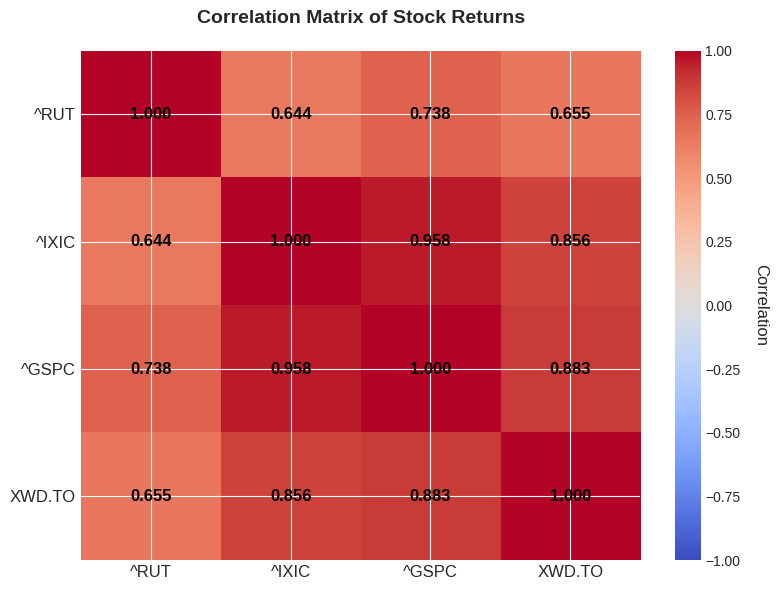

In [31]:
# Calculate correlation matrix
Corr = data_R.corr()

print("Correlation Matrix:")
print(Corr.round(4))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(Corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(Tickers, fontsize=12)
ax.set_yticklabels(Tickers, fontsize=12)

# Add correlation values
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, f'{Corr.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20, fontsize=12)

ax.set_title('Correlation Matrix of Stock Returns', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Markowitz Framework - Without Risk-Free Asset

Following the notation from our reference document, we calculate:

**Key parameters:**
- $a = 1_n' \Sigma^{-1} 1_n$ (scalar product)
- $b = M' \Sigma^{-1} 1_n$ (scalar product)

**Minimum Variance Portfolio** ($\pi_a$):
$$\pi_a = \frac{1}{a}\Sigma^{-1}1_n$$

Properties:
- Expected return: $m_{\pi_a} = \frac{b}{a}$
- Volatility: $\sigma_{\pi_a} = \frac{1}{\sqrt{a}}$

In [32]:
# Create vector of ones (1_n)
Vec1 = np.ones(n)

# Calculate inverse of Sigma
InvSigma = inv(Sigma)

# Calculate key parameters a and b
a = Vec1.T @ InvSigma @ Vec1  # a = 1_n' Sigma^{-1} 1_n
b = M.T @ InvSigma @ Vec1      # b = M' Sigma^{-1} 1_n

print("=" * 60)
print("KEY PARAMETERS (Markowitz Framework)")
print("=" * 60)
print(f"a = 1_n' Σ^(-1) 1_n = {a:.6f}")
print(f"b = M' Σ^(-1) 1_n = {b:.6f}")

# Calculate minimum variance portfolio π_a
pi_a = (1/a) * InvSigma @ Vec1

# Properties of minimum variance portfolio
m_a = b / a  # Expected return
sigma_a = 1 / math.sqrt(a)  # Volatility

print("\n" + "=" * 60)
print("MINIMUM VARIANCE PORTFOLIO (π_a)")
print("=" * 60)
print("\nWeights:")
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {pi_a[i]:.4f} ({pi_a[i]*100:.2f}%)")
print(f"\nSum of weights: {pi_a.sum():.4f}")

print(f"\nExpected return (m_a): {m_a:.4f} ({m_a*100:.2f}%)")
print(f"Volatility (σ_a): {sigma_a:.4f} ({sigma_a*100:.2f}%)")
print(f"Sharpe Ratio: {(m_a - r0)/sigma_a:.4f}")

KEY PARAMETERS (Markowitz Framework)
a = 1_n' Σ^(-1) 1_n = 193.039488
b = M' Σ^(-1) 1_n = 45.166067

MINIMUM VARIANCE PORTFOLIO (π_a)

Weights:
  ^RUT: -0.1865 (-18.65%)
  ^IXIC: -0.9791 (-97.91%)
  ^GSPC: 1.2137 (121.37%)
  XWD.TO: 0.9519 (95.19%)

Sum of weights: 1.0000

Expected return (m_a): 0.2340 (23.40%)
Volatility (σ_a): 0.0720 (7.20%)
Sharpe Ratio: 3.1119


In [37]:
# Sharpe Ratio of each asset
SR = (M - r0) / STD
print("\n" + "=" * 60)
print("SHARPE RATIO OF EACH ASSET")
print("=" * 60)
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {SR.iloc[i]:.4f}")


SHARPE RATIO OF EACH ASSET
  ^RUT: 0.5488
  ^IXIC: 1.5241
  ^GSPC: 1.6856
  XWD.TO: 2.6874


## Tangent Portfolio - With Risk-Free Asset

When a risk-free asset with return $r_0$ is available, the optimal risky portfolio is the **Tangent Portfolio** ($\pi_T$):

$$\pi_T = \frac{1}{b - r_0 a}\Sigma^{-1}(M - r_0 1_n)$$

This portfolio:
- Has the **maximum Sharpe ratio** among all risky portfolios
- Lies on the **Capital Market Line (CML)**
- Is the optimal combination of risky assets for all investors (Two-Fund Separation)

In [33]:
# Calculate Tangent Portfolio π_T
pi_T = (1 / (b - r0 * a)) * InvSigma @ (M - r0 * Vec1)

# Properties of tangent portfolio
m_T = pi_T @ M  # Expected return
sigma_T = math.sqrt(pi_T @ Sigma @ pi_T)  # Volatility
SR_T = (m_T - r0) / sigma_T  # Sharpe Ratio

print("=" * 60)
print("TANGENT PORTFOLIO (π_T)")
print("=" * 60)
print("\nWeights in risky assets:")
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {pi_T[i]:.4f} ({pi_T[i]*100:.2f}%)")
print(f"\nSum of weights: {pi_T.sum():.4f}")

print(f"\nExpected return (m_T): {m_T:.4f} ({m_T*100:.2f}%)")
print(f"Volatility (σ_T): {sigma_T:.4f} ({sigma_T*100:.2f}%)")
print(f"Sharpe Ratio (SR_T): {SR_T:.4f}")

print("\n" + "-" * 60)
print("COMPARISON: Minimum Variance vs Tangent Portfolio")
print("-" * 60)
print(f"{'Metric':<25} {'Min Var (π_a)':<20} {'Tangent (π_T)':<20}")
print("-" * 60)
print(f"{'Expected Return':<25} {m_a*100:>18.2f}% {m_T*100:>18.2f}%")
print(f"{'Volatility':<25} {sigma_a*100:>18.2f}% {sigma_T*100:>18.2f}%")
print(f"{'Sharpe Ratio':<25} {(m_a-r0)/sigma_a:>18.4f} {SR_T:>18.4f}")

TANGENT PORTFOLIO (π_T)

Weights in risky assets:
  ^RUT: -0.2583 (-25.83%)
  ^IXIC: -0.5332 (-53.32%)
  ^GSPC: 0.2772 (27.72%)
  XWD.TO: 1.5143 (151.43%)

Sum of weights: 1.0000

Expected return (m_T): 0.2996 (29.96%)
Volatility (σ_T): 0.0818 (8.18%)
Sharpe Ratio (SR_T): 3.5385

------------------------------------------------------------
COMPARISON: Minimum Variance vs Tangent Portfolio
------------------------------------------------------------
Metric                    Min Var (π_a)        Tangent (π_T)       
------------------------------------------------------------
Expected Return                        23.40%              29.96%
Volatility                              7.20%               8.18%
Sharpe Ratio                          3.1119             3.5385


## Efficient Frontier and Capital Market Line Visualization

The **Efficient Frontier** $\mathcal{F}$ is a hyperbola in $(σ, m)$ space representing all efficient portfolios.

The **Capital Market Line (CML)** $\mathcal{C}$ is a straight line from $(0, r_0)$ tangent to $\mathcal{F}$ at the tangent portfolio.

For the frontier, we use:
$$\sigma^2 = \left(\frac{m - m_a}{m_w}\right)^2 + \sigma_a^2$$

where $m_w = \|M - \frac{b}{a}1_n\|_{\Sigma^{-1}}$

check mean equality: 0.2339732019550627 0.23397320195506288
check var equality: 0.07197421238366952 0.07197421238366955


/tmp/ipykernel_534190/2691549433.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(Tickers[0], (STD[0], M[0]))
/tmp/ipykernel_534190/2691549433.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(Tickers[1], (STD[1], M[1]))
/tmp/ipykernel_534190/2691549433.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(Tickers[2], (STD[2], M[2]))
/tmp/ipykernel_534190/2691549433.py:67: FutureWarning: Ser

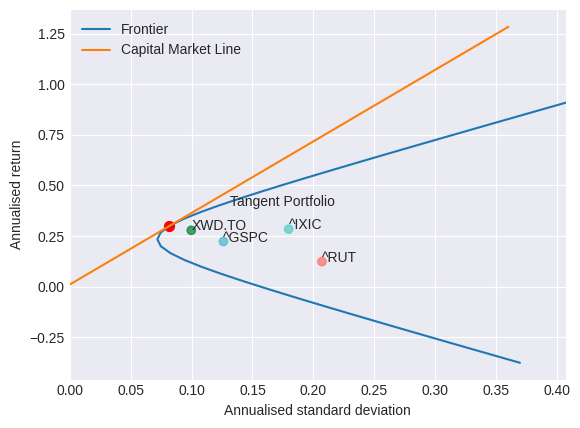

In [39]:
from numpy.linalg import inv
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

r = 0.01  # risk-free rate
d = len(Tickers)
Vec1 = np.linspace(1, 1, d)
InvSigma = inv(Sigma)

# Important variables calculation
a = Vec1.T.dot(InvSigma).dot(Vec1)
b = M.T.dot(InvSigma).dot(Vec1)

# Portfolio of minimal variance
pi_a = InvSigma.dot(Vec1) / a
sd_a = 1 / np.sqrt(a)
m_a = b / a

print("check mean equality:", m_a, pi_a.T.dot(M))
print("check var equality:", sd_a, np.sqrt(pi_a.T.dot(Sigma).dot(pi_a)))

# Self financing Portfolio
m_w = np.sqrt((M - b / a * Vec1).T.dot(InvSigma).dot(M - b / a * Vec1))  # expected excess return

# Tangent Portfolio
pi_T = InvSigma.dot(M - r * Vec1) / (b - r * a)
sd_T = np.sqrt(pi_T.T.dot(Sigma).dot(pi_T))
m_T = pi_T.T.dot(M)

# Graph plot
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', "#027E33"]

range_inf = np.min(M) - 0.5
range_sup = np.max(M) + 1
y = np.linspace(range_inf, range_sup, 50)
x_1 = pd.DataFrame()  # sigma Frontier
x_2 = pd.DataFrame()  # sigma CML

i = 0
for i in range(len(y)):  # values of m
    x_1[i] = [np.sqrt(((y[i] - m_a) ** 2 / m_w ** 2) + sd_a ** 2)]  # Frontier
    x_2[i] = [(y[i] - r) / (m_T - r) * sd_T]  # Capital Market Line

xf_1 = x_1.iloc[0]
xc_1 = x_2.iloc[0]

range_inf_x = 0
range_sup_x = np.max(STD) + 0.2
plt.xlim(range_inf_x, range_sup_x)

plt.plot(xf_1, y, alpha=1, label='Frontier')
plt.plot(xc_1, y, alpha=1, label='Capital Market Line')
plt.legend(['Frontier', 'Capital Market Line'], loc=2)

plt.scatter(STD, M, c=colors, alpha=0.7)  # plot the assets
plt.grid(True)
plt.xlabel('Annualised standard deviation')
plt.ylabel('Annualised return')

plt.scatter(sd_T, m_T, color='red', s=50, alpha=1)  # Tangent portfolio point
ax.annotate('Tangent Portfolio', (sd_T + 0.05, m_T + 0.10))

ax.annotate(Tickers[0], (STD[0], M[0]))
ax.annotate(Tickers[1], (STD[1], M[1]))
ax.annotate(Tickers[2], (STD[2], M[2]))
ax.annotate(Tickers[3], (STD[3], M[3]))

plt.show()